In [7]:
# This cell is replaced by snakemake
from types import SimpleNamespace

snakemake = SimpleNamespace(
    input=SimpleNamespace(
        markers=None,
        haplotypes=None,
    ),
    output=SimpleNamespace(
        html="/dev/null",
    ),
    config={
        "dataset": "sample1",
    },
    wildcards=SimpleNamespace(
        dataset_name="col0xler7068"
    ),
    log={},
    threads=4,
    resources={},
    rule="generate_haplotyping_report"
)


In [77]:
import numpy as np
from matplotlib import pyplot as plt
from snco import MarkerRecords, PredictionRecords
from snco.records import NestedData

### Report for analysis of {{ snakemake.wildcards["dataset_name"] }}

In [10]:
markers = MarkerRecords.read_json(snakemake.input.markers)
markers

Cell barcode,Marker counts
AACTGAAAGATTCCAG,"Chr1: 112, Chr2: 42, Chr3: 153, Chr4: 71, Chr5: 87"
CGGTGAGGTAACGATG,"Chr1: 602, Chr2: 119, Chr3: 775, Chr4: 453, Chr5: 342"
GCCCTAGAGTTACCCT,"Chr1: 57, Chr2: 41, Chr3: 109, Chr4: 28, Chr5: 70"
AATATGCTCATAGGAA,"Chr1: 378, Chr2: 125, Chr3: 487, Chr4: 312, Chr5: 188"
AACCTAACAGCCTATC,"Chr1: 102, Chr2: 58, Chr3: 142, Chr4: 78, Chr5: 85"
CCCAATCCAAAGGGAC,"Chr1: 432, Chr2: 428, Chr3: 748, Chr4: 292, Chr5: 593"
GGTGAGGCATCCAAGG,"Chr1: 146, Chr2: 49, Chr3: 215, Chr4: 105, Chr5: 90"
CGCCTTGCATAAGCAC,"Chr1: 686, Chr2: 125, Chr3: 726, Chr4: 342, Chr5: 274"
ACAGCTCAGCCCTGTC,"Chr1: 461, Chr2: 93, Chr3: 853, Chr4: 319, Chr5: 206"
CCTCAAGGTTTCACTT,"Chr1: 569, Chr2: 305, Chr3: 525, Chr4: 373, Chr5: 448"


In [11]:
haplotypes = PredictionRecords.read_json(snakemake.input.haplotypes)
haplotypes

Cell barcode,Estimated crossovers
AACTGAAAGATTCCAG,"Chr1: 1.90, Chr2: 0.00, Chr3: 0.00, Chr4: 1.08, Chr5: 0.75"
CGGTGAGGTAACGATG,"Chr1: 0.55, Chr2: 0.92, Chr3: 0.94, Chr4: 0.00, Chr5: 0.00"
GCCCTAGAGTTACCCT,"Chr1: 1.25, Chr2: 0.04, Chr3: 1.05, Chr4: 0.28, Chr5: 1.43"
AATATGCTCATAGGAA,"Chr1: 0.85, Chr2: 0.00, Chr3: 1.14, Chr4: 0.94, Chr5: 0.98"
AACCTAACAGCCTATC,"Chr1: 2.84, Chr2: 1.06, Chr3: 1.88, Chr4: 0.27, Chr5: 1.57"
CCCAATCCAAAGGGAC,"Chr1: 0.00, Chr2: 0.00, Chr3: 0.97, Chr4: 1.00, Chr5: 0.00"
GGTGAGGCATCCAAGG,"Chr1: 0.95, Chr2: 0.39, Chr3: 1.42, Chr4: 1.42, Chr5: 1.38"
CGCCTTGCATAAGCAC,"Chr1: 0.99, Chr2: 0.00, Chr3: 0.67, Chr4: 0.00, Chr5: 0.43"
ACAGCTCAGCCCTGTC,"Chr1: 0.97, Chr2: 0.99, Chr3: 1.02, Chr4: 0.00, Chr5: 3.68"
CCTCAAGGTTTCACTT,"Chr1: 2.93, Chr2: 0.99, Chr3: 4.79, Chr4: 1.99, Chr5: 0.99"


## Number of informative reads

The number of reads that distinguish haplotypes is dependent on the sequencing stragety, library complexity, and sequencing depth, as well as the number of (mappable) SNPs that actually distinguish the two haplotypes. This dataset has already been filtered to remove barcodes with fewer than {{ snakemake.config["haplotyping"]["preprocessing"]["min_informative_reads_per_barcode"] }} informative reads.

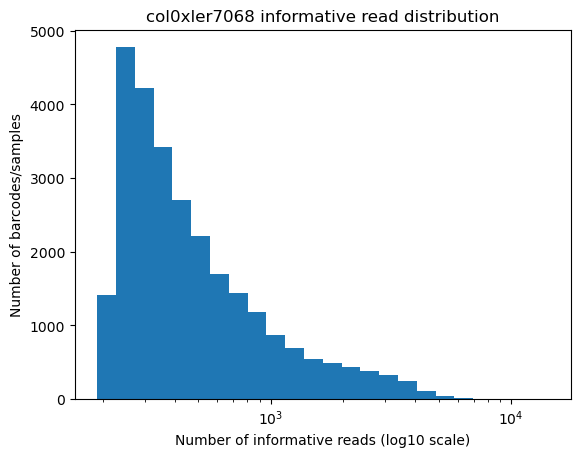

In [70]:
marker_counts = [markers.total_marker_count(cb) for cb in markers.barcodes]
fig, ax = plt.subplots()
ax.hist(
    marker_counts,
    bins=np.logspace(np.log10(min(marker_counts)), np.log10(max(marker_counts)), 25),
)
plt.xscale('log')
ax.set_xlabel('Number of informative reads (log10 scale)')
ax.set_ylabel('Number of barcodes/samples')
ax.set_title(f'{snakemake.wildcards.dataset_name} informative read distribution')
plt.show()

## Doublet probabilities

`snco` performs doublet detection for single cell datasets using "synthetic doublets", created by mixing multiple barcodes together. Several summary statistics are calculated and the K-nearest neighbours classification is used to produce a score (for real data vs synthetic doublets). The choice of filtering threshold to remove doublets can vary with dataset/application and is left up to the user.

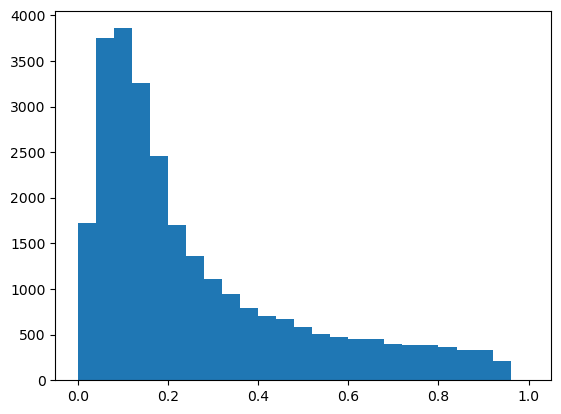

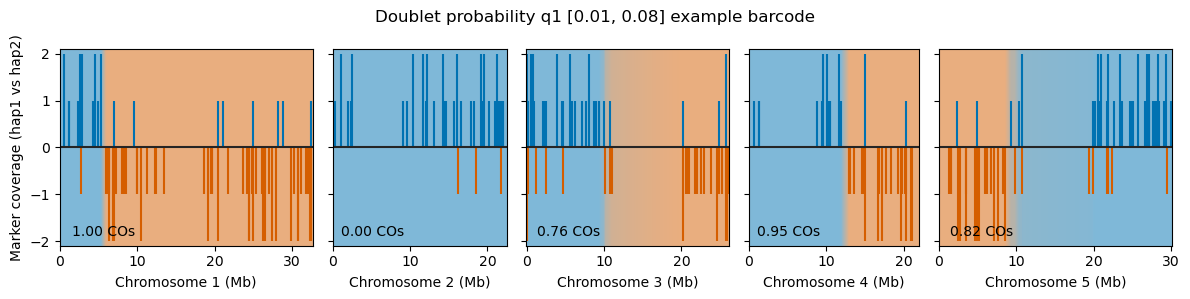

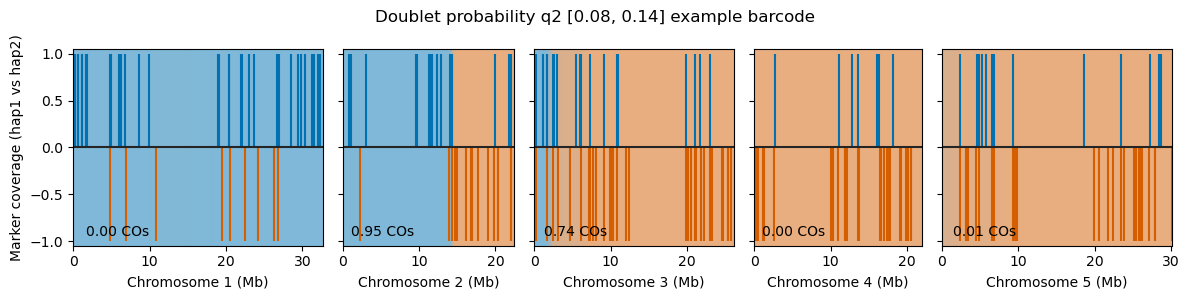

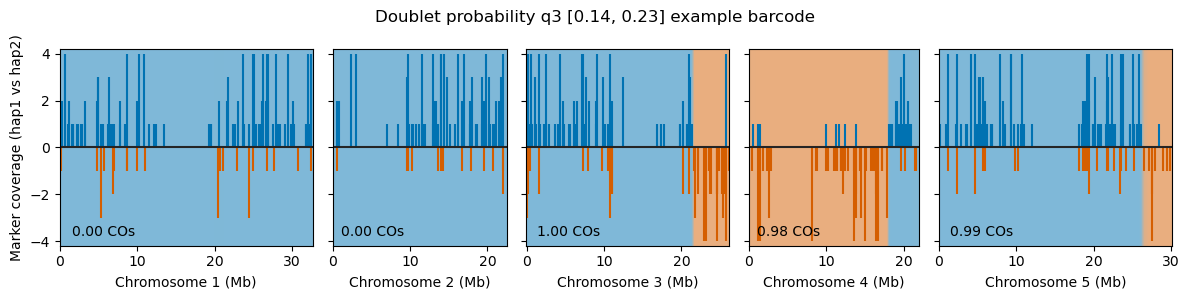

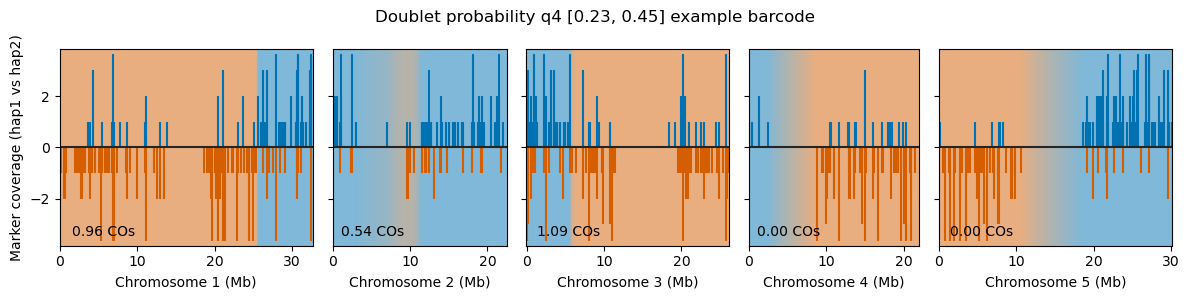

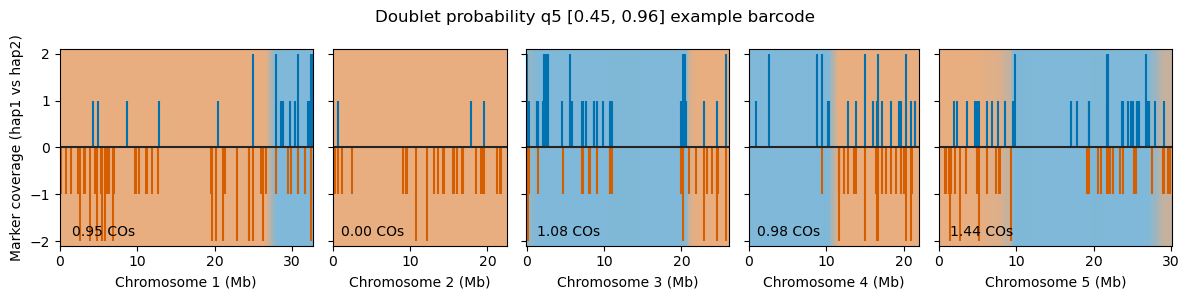

In [68]:
def qcutter(q, doublet_probs):
    x = np.asarray(list(doublet_probs.values()))
    quantiles = np.linspace(0, 100, q + 1)
    bins = np.percentile(x, quantiles)
    bins[0] -= 1e-8  # ensure inclusion of min value
    labels = [f'[{bins[i]:.2f}, {bins[i+1]:.2f}]' for i in range(q)]
    def _wrapped(cb):
        i = np.digitize(doublet_probs[cb], bins[1:-1], right=True)
        return labels[i]
    return _wrapped

if hasattr(haplotypes, 'doublet_probability'):
    plt.hist(
        list(haplotypes.doublet_probability.values()),
        bins=25, range=(0, 1),
    )
    plt.show()
    quantile_separated_barcodes = dict(markers.groupby(qcutter(5, haplotypes.doublet_probability)))
    for i, q in enumerate(sorted(quantile_separated_barcodes)):
        markers_group = quantile_separated_barcodes[q]
        cb = np.random.choice(markers_group.barcodes)
        fig, axes = markers_group.plot_barcode(cb, co_preds=haplotypes, max_yheight='auto', figsize=(12, 3))
        fig.suptitle(f'Doublet probability q{i+1} {q} example barcode')
        plt.tight_layout()
        plt.show()

## Filtering

You can create your own quality control filters here - this is just an example that is generally suitable for 10x RNA data

In [83]:
haplotypes.add_metadata(
    total_marker_count=NestedData(
        ['cb'], int, {cb: int(markers.total_marker_count(cb)) for cb in markers.barcodes}
    )
)
haplotypes_filt = haplotypes.query('(doublet_probability < 0.25) & (total_marker_count > 300)')
markers_filt = markers.filter(haplotypes.barcodes, inplace=False)

### Segregation distortion

We can plot the overall allele frequencies of the dataset to look for single locus distortions (these can sometimes be affected by noise in the data, if you see weird/extreme patterns then perhaps stricter data cleaning/filtering is required).

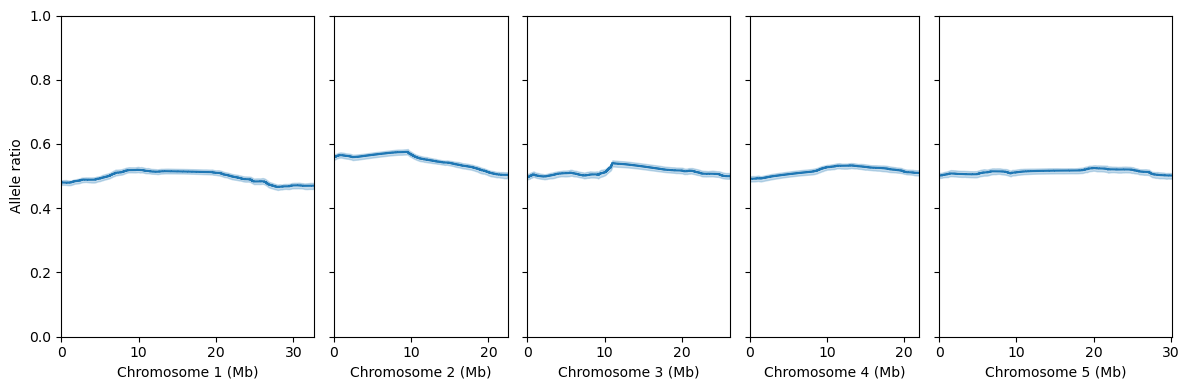

In [86]:
haplotypes.plot_allele_ratio()
plt.show()

### Crossover distributions